# 前置準備

In [1]:
# ## 安裝 keras 及 下載 keras-yolo3
# !pip install keras==2.2.4                                       # 安裝 keras 2.2.4 的版本
# !git clone https://github.com/qqwweee/keras-yolo3               # 使用 keras-yolo3 
%cd keras-yolo3

# # 訓練資料集下載
# !git clone https://github.com/experiencor/kangaroo.git          # kangaroo 圖片集
# !git clone https://github.com/experiencor/raccoon_dataset.git   # raccoon 圖片集

# # 下載測試資料
# !mkdir test
# !wget 'https://dehayf5mhw1h7.cloudfront.net/wp-content/uploads/sites/726/2017/08/03065555/Kangacoon-1024x768.jpg' -O 'test/Kan_Raccoon1.jpg'

# !mkdir video
# !wget -c 'https://cvdl.cupoy.com/HomeworkAction.do?op=getHomeworkFileContent&hwid=D49&filepath=Raccoon.mp4' -O 'video/Raccoon.mp4'      # kangaroo 測試影片
# !wget -c 'https://cvdl.cupoy.com/HomeworkAction.do?op=getHomeworkFileContent&hwid=D49&filepath=Kangaroo.mp4' -O 'video/Kangaroo.mp4'    # kangaroo 測試影片


/content/keras-yolo3


In [2]:
# 安裝相關套件 ，將 training 所需要的套件載入
import os
import subprocess
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.utils import get_random_data
from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import tensorflow as tf


Using TensorFlow backend.


# 資料集影像處理 (解析 xml 資料)


* 解析 xml 資料到 animals_train.txt 
* 自定義convert_annotation
 * 使用 tree.iter('object') 拆解xml內容
 * cls_name 分類至 cls_index  (0,1)
 * bndbox 顯示影像方框

* 設定圖片檔案位置，列出影像位置
      images_dir = ['kangaroo/images', 'raccoon_dataset/images'] 

In [0]:
import xml.etree.ElementTree as ET                 # 載入能夠 Parser xml 文件的 library

# 資料集格式轉換
if not os.path.exists('animals_train.txt'):
    sets = ['train', 'val']
    
    classes = ["kangaroo", "raccoon"]
    
    def convert_annotation(xml_path, list_file):
        f = open(xml_path)
        tree = ET.parse(f)
        root = tree.getroot()
        
        for obj in tree.iter('object'):
            diff = int(obj.find('difficult').text)
            cls_name = obj.find('name').text
            
            if cls_name not in classes or diff == 1:
                continue
                
            cls_index = classes.index(cls_name)
            bndbox = obj.find('bndbox')
            
            b = (int(bndbox.find('xmin').text), 
                int(bndbox.find('ymin').text), 
                int(bndbox.find('xmax').text), 
                int(bndbox.find('ymax').text))

            list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_index))
            
        f.close()
        
    
    images_dir = ['kangaroo/images', 'raccoon_dataset/images']
    for s in sets:
        list_file = open(f'animals_{s}.txt', 'w')
        
        for i, annotation_path in enumerate(['kangaroo/annots', 'raccoon_dataset/annotations']):
            annots = os.listdir(annotation_path)
            annots.sort()
            annot_size = len(annots)
            split_num = int(np.round(annot_size * 0.8))
        
            if s == 'train':
                data = annots[:split_num]
            else:
                data = annots[split_num:]
                
            for d in data:
                name = d.split('.')[0]
                list_file.write(os.path.join(images_dir[i], f'{name}.jpg'))
                convert_annotation(os.path.join(annotation_path, d), list_file)
                list_file.write('\n')
        
        list_file.close()

In [0]:
# 設定訓練資料來源位置， training data 以及 validation 比例

annotation_path = 'animals_train.txt'                                  # 轉換好格式的標註檔案
log_dir = 'logs/000/'                                                  # 訓練好的模型儲存的路徑
classes_path = 'model_data/animal_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'

class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)


# 分為 training 以及 validation
val_split = 0.25
with open(annotation_path) as f:
    train_lines = f.readlines()

with open('animals_val.txt') as f:
    val_lines = f.readlines()

np.random.seed(10101)
np.random.shuffle(train_lines)
np.random.seed(None)
num_val = len(val_lines)
num_train = len(train_lines)

# yolo3 模型設定與訓練


In [5]:
#  載入 yolov3 Keras模型與權重

if not os.path.exists("model_data/yolo.h5"):                    # 載入 yolov3 Keras模型 (hdf5存储格式)
    print("Model doesn't exist, downloading...")
    os.system("wget https://pjreddie.com/media/files/yolov3.weights")
    print("Converting yolov3.weights to yolo.h5...")
    os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
    print("Model exist")

if not os.path.exists("model_data/yolo_weights.h5"):             # 載入 yolov3 的網路權重
    print("Converting pretrained YOLOv3 weights for training")
    os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
    print("Pretrained weights exists")

Model exist
Pretrained weights exists


In [6]:
# 模型參數設定 ，設定logging, checkpoint, reduce_lr, early_stopping

input_shape = (416,416)                                                 # multiple of 32, hw

is_tiny_version = len(anchors)==6                                       # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo.h5')
else:
    model = create_model(input_shape, anchors, num_classes, 
        freeze_body=2, weights_path='model_data/yolo_weights.h5')       # make sure you know what you freeze


logging = TensorBoard(log_dir=log_dir)

checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                             monitor='val_loss', 
                             save_weights_only=True, 
                             save_best_only=True, 
                             period=3)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta=0.001, 
                               patience=20, 
                               verbose=1)














Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
# yoloV3模型訓練

%tensorflow_version 1.x           # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
print(tf.__version__)

# 自定義圖像擴增 data_generator
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes, is_train=True):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0 and is_train:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=is_train)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)




# 第一階段訓練: 先 freeze YOLO (除了 output layer) 以 backbone Model (yolo.h5) 及預設的權重 來 train 模型

if True:
    batch_size=5
    model.compile(optimizer=Adam(lr=1e-3), loss={'yolo_loss': lambda y_true, y_pred: y_pred})           # use custom yolo_loss Lambda layer.
    print(f'第一階段訓練 : Train on {num_train} samples, val on {num_val} samples, with batch size {batch_size}.')

    history1 = model.fit_generator(data_generator(train_lines, batch_size, input_shape, anchors, num_classes, True),
            steps_per_epoch=max(1, num_train//batch_size),
            epochs=75,
            validation_data=data_generator(val_lines, batch_size, input_shape, anchors, num_classes, False),
            validation_steps=max(1, num_val//batch_size),
            initial_epoch=0,
            callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')





# 第二階段訓練: 把所有 layer 都改為 trainable ，做 fine-tune

if True:
    print('\n 第二階段訓練 : Unfreeze all of the layers.')
    for i in range(len(model.layers)):                            # 把所有 layer 都改為 trainable
        model.layers[i].trainable = True

    batch_size=3                                                  # note that more GPU memory is required after unfreezing the body       
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred})      # recompile to apply the change
    print(f'Train on {num_train} samples, val on {num_val} samples, with batch size {batch_size}.')

    history2 = model.fit_generator(data_generator(train_lines, batch_size, input_shape, anchors, num_classes, True),
        steps_per_epoch=max(1, num_train//batch_size),
        epochs=25,
        validation_data=data_generator(val_lines, batch_size, input_shape, anchors, num_classes, False),
        validation_steps=max(1, num_val//batch_size),
        initial_epoch=0,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
 
    model.save_weights(log_dir + 'trained_weights_final.h5')

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x           # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
1.15.0

第一階段訓練 : Train on 291 samples, val on 73 samples, with batch size 5.




Epoch 1/75
58/58 [==============================] - 31s 537ms/step - loss: 2067.6716 - val_loss: 217.1124

Epoch 2/75
58/58 [==============================] - 25s 438ms/step - loss: 178.2367 - val_loss: 104.3339
Epoch 3/75
58/58 [==============================] - 27s 460ms/step - loss: 106.7259 - val_loss: 70.1309
Epoch 4/75
58/58 [==============================] - 24s 414ms/step - loss: 74.6783 - val_loss: 52.6602
Epoch 5/75
58/58 [==============================] - 27s 465ms/step - loss: 59.3895 - val_loss: 43.1946
Epoch 6/75
58/58 [==============================] - 27s 460ms/step - loss: 49.9682 - val_loss: 37.2929
Epoch 7/75
58/58 [================

Text(0.5, 0, 'epochs')

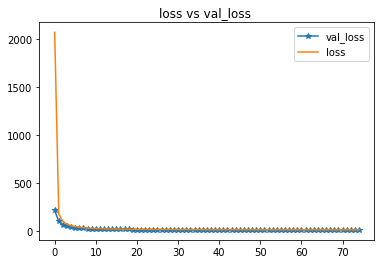

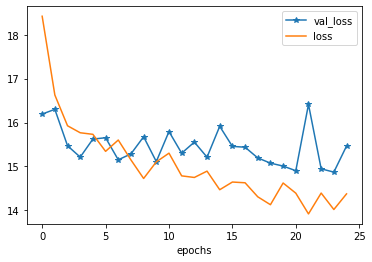

In [8]:
# 繪出 訓練過程 val_loss 與 loss 的變化

import matplotlib.pyplot as plt

plt.figure()
plt.title('loss vs val_loss ')  
plt.plot(history1.history["val_loss"], "-*" ,  label="val_loss")
plt.plot(history1.history["loss"], label="loss")
plt.legend(loc='upper right')

plt.figure()
plt.plot(history2.history["val_loss"], "-*" ,  label="val_loss")
plt.plot(history2.history["loss"], label="loss")
plt.legend(loc='upper right')
plt.xlabel("epochs")

# plt.savefig('history.png')
# model.summary()

# 模型評估

In [9]:
# 載入yolo模型 與 訓練後的權重

from yolo import YOLO

yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)

logs/000/trained_weights_final.h5 model, anchors, and classes loaded.


# picture detector

(416, 416, 3)
Found 2 boxes for img
raccoon 0.95 (448, 52) (1015, 768)
kangaroo 0.99 (18, 116) (420, 689)
2.5729729239974404


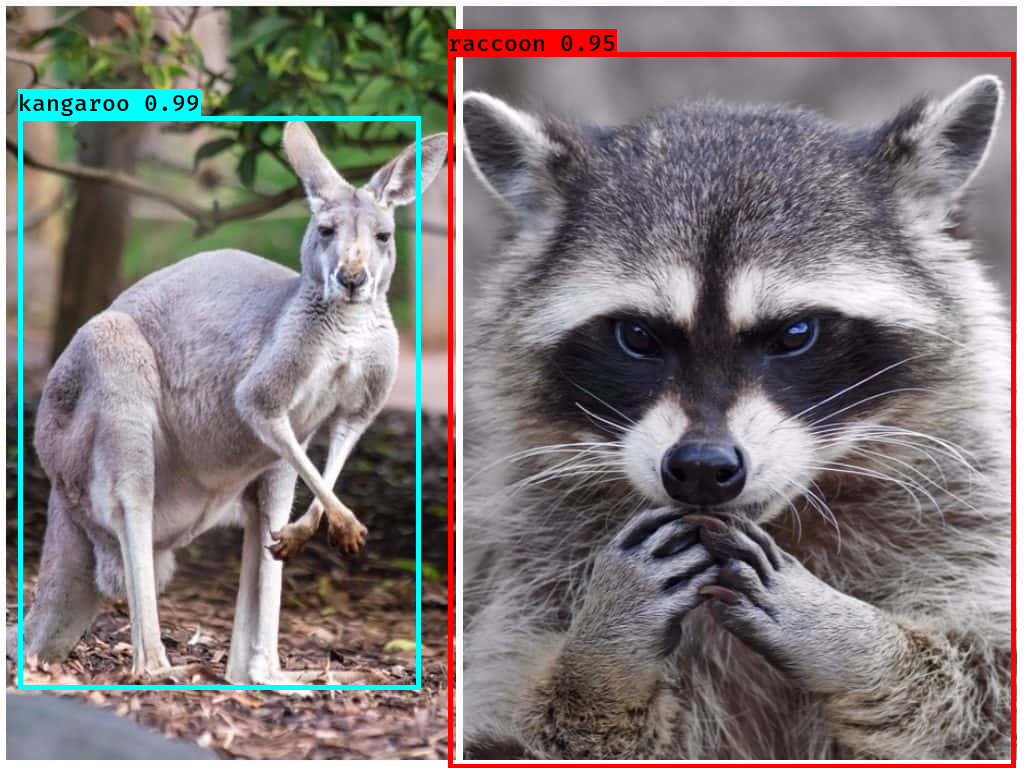

In [10]:
from PIL import Image
from IPython import display

for file in os.listdir('test'):
    image = Image.open(os.path.join('test/', file))      # 讀取範例圖片
    r_img = yolo_model.detect_image(image)               # 執行 yolo 檢測，將回傳的圖片儲存在 r_image 中
    display.display(r_img)                               # 顯示 r_image，可觀察到圖片上已畫上 yolov3 所檢測的 object

# video detector


In [0]:
# 參照來源: https://github.com/gausschang/1st-DL-CVMarathon/blob/master/Day050_HomeWork.ipynb

def video_detect(video_path, output_path):
    import cv2
    import numpy as np
    from PIL import Image
    import timeit

    starttime = timeit.default_timer()
    cap = cv2.VideoCapture(video_path)

    # 使用 XVID 編碼
    fourcc = cv2.VideoWriter_fourcc(*'XVID')

    # 建立 VideoWriter 物件，輸出影片至 output.avi , FPS 值為 30.0，解析度為 1280*720
    out = cv2.VideoWriter(output_path, fourcc, 30.0, (1280, 720))

    k = 0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            # 寫入影格
            image = Image.fromarray(frame)
            image = np.array(yolo_model.detect_image(image))
            out.write(image)
            k += 1
        else:
            break
        
    # 釋放所有資源
    cap.release()
    out.release()
    print('共耗時:',round((timeit.default_timer() - starttime), 2), '秒，FPS:', round(k/(timeit.default_timer() - starttime), 2))

In [12]:
video_path = 'video/Kangaroo.mp4'
output_path = 'video/Kangaroo-yolo.mp4'
video_detect(video_path=video_path, output_path=output_path)

Streaming output truncated to the last 5000 lines.
kangaroo 0.65 (549, 343) (1057, 714)
0.053019104001577944
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.51 (10, 92) (202, 412)
kangaroo 0.65 (549, 343) (1057, 714)
0.055031923002388794
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.61 (9, 95) (205, 410)
kangaroo 0.73 (549, 342) (1058, 715)
0.06779690500115976
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.66 (9, 99) (207, 407)
kangaroo 0.75 (554, 339) (1054, 715)
0.05301252199933515
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.67 (10, 98) (210, 408)
kangaroo 0.77 (556, 336) (1055, 718)
0.0526732219987025
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.65 (8, 95) (215, 411)
kangaroo 0.80 (553, 341) (1064, 715)
0.05586782899990794
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.65 (8, 95) (215, 411)
kangaroo 0.80 (552, 341) (1064, 715)
0.053501447000599
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.69 (7, 88) (220, 417)
kangaroo 0.83 (553, 338) (1067, 717)
0.05478680299711414
(416, 416

In [13]:
video_path = 'video/Raccoon.mp4'
output_path = 'video/Raccoon-yolo.mp4'
video_detect(video_path=video_path, output_path=output_path)

Streaming output truncated to the last 5000 lines.
(416, 416, 3)
Found 2 boxes for img
raccoon 0.43 (717, 14) (1280, 666)
raccoon 0.76 (0, 26) (1275, 670)
0.05558413700055098
(416, 416, 3)
Found 2 boxes for img
raccoon 0.52 (731, 14) (1280, 666)
raccoon 0.73 (1, 26) (1267, 672)
0.05292926200127113
(416, 416, 3)
Found 2 boxes for img
raccoon 0.36 (732, 11) (1280, 671)
raccoon 0.78 (0, 32) (1276, 669)
0.0525279009998485
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (0, 17) (1280, 679)
0.052609455000492744
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (0, 14) (1280, 684)
0.050296188001084374
(416, 416, 3)
Found 2 boxes for img
raccoon 0.31 (714, 8) (1280, 675)
raccoon 0.86 (0, 20) (1280, 683)
0.05102837899903534
(416, 416, 3)
Found 2 boxes for img
raccoon 0.48 (722, 10) (1280, 675)
raccoon 0.84 (0, 28) (1280, 677)
0.05564622900055838
(416, 416, 3)
Found 2 boxes for img
raccoon 0.51 (695, 35) (1226, 661)
raccoon 0.85 (1, 26) (1265, 678)
0.07052280400239397
(416, 416, 3)
Found 2 boxes

# 補充資料

In [0]:
# https://blog.csdn.net/huyun9666/article/details/88697128

# fit 中的 verbose
# verbose：日志显示
# verbose = 0 为不在标准输出流输出日志信息
# verbose = 1 为输出进度条记录
# verbose = 2 为每个epoch输出一行记录
# 注意： 默认为 1

#  
# evaluate 中的 verbose
# verbose = 0 为不在标准输出流输出日志信息
# verbose = 1 为输出进度条记录
# 注意： 只能取 0 和 1；默认为 1

In [0]:
# import io
# import base64
# from IPython.display import HTML

# def playvideo(filename):
#     video = io.open(filename, 'r+b').read()
#     encoded = base64.b64encode(video)
#     return HTML(data='''<video alt="test" controls>
#                     <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
#                  </video>'''.format(encoded.decode('ascii')))
    
# playvideo('video/Raccoon-yolo.mp4')